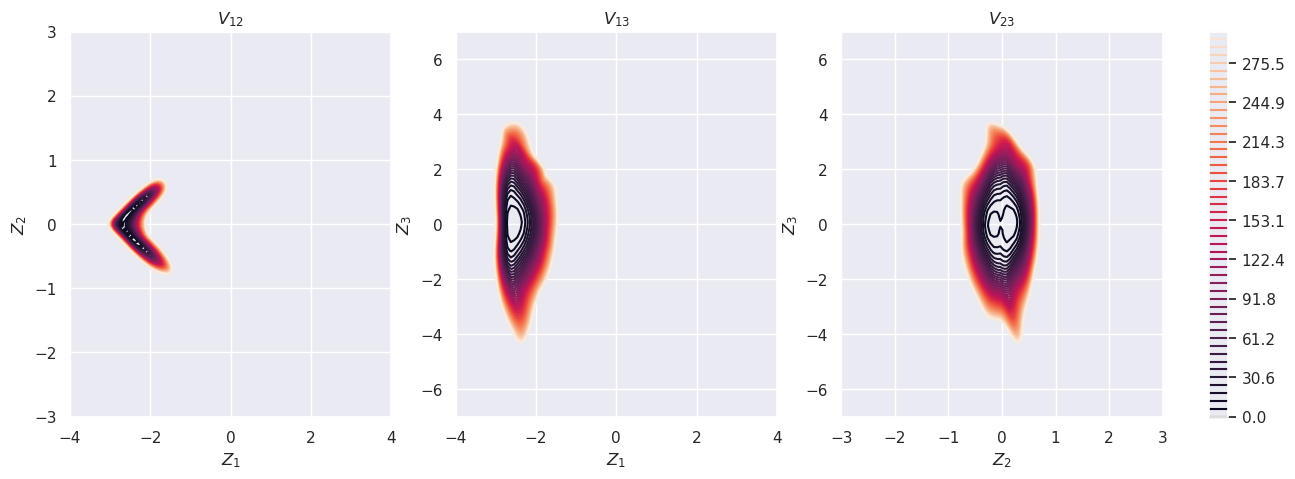

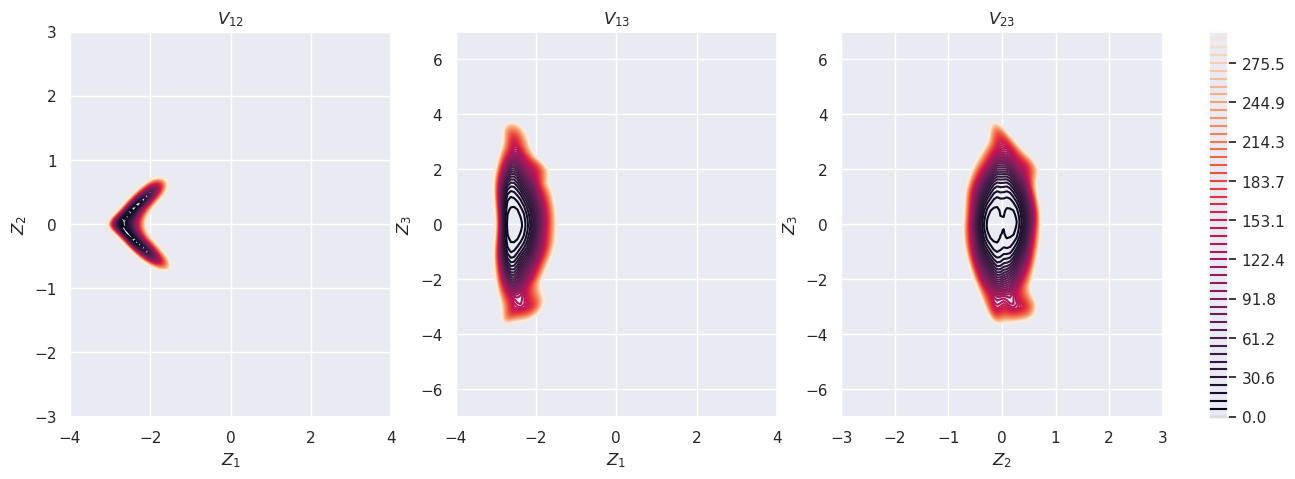

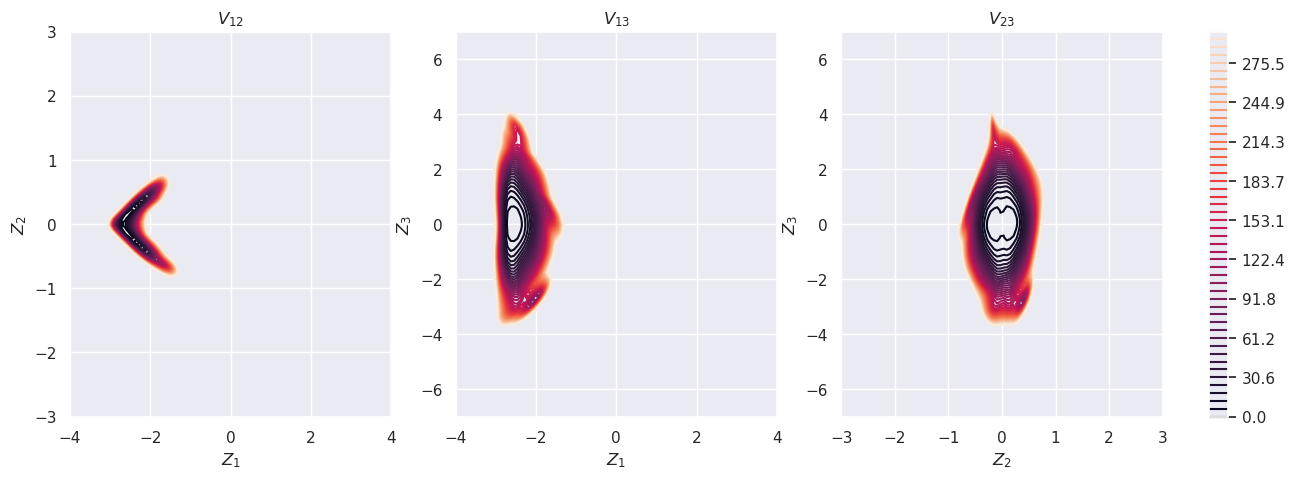

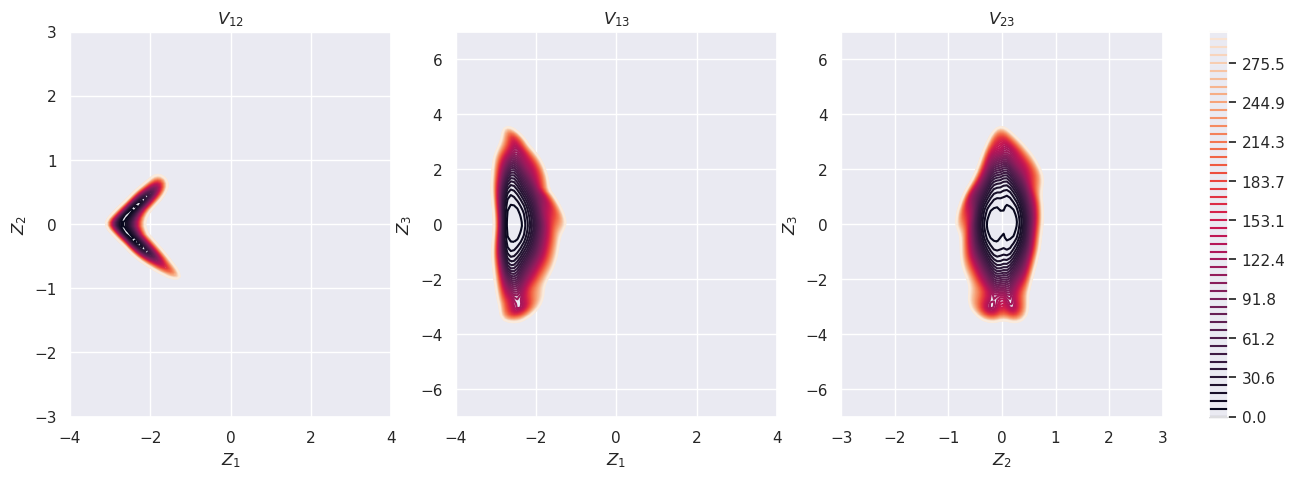

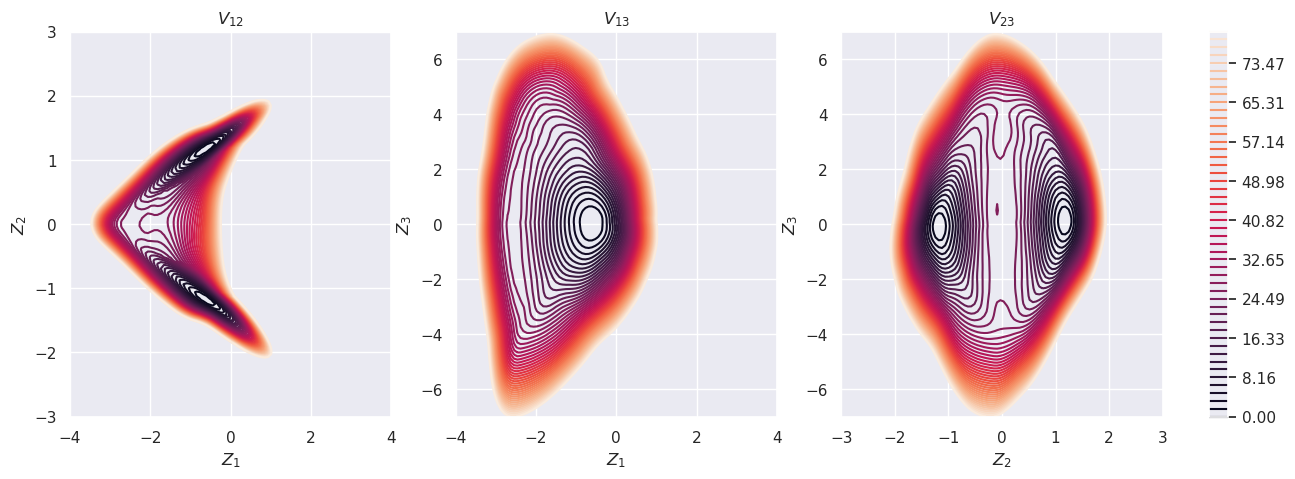

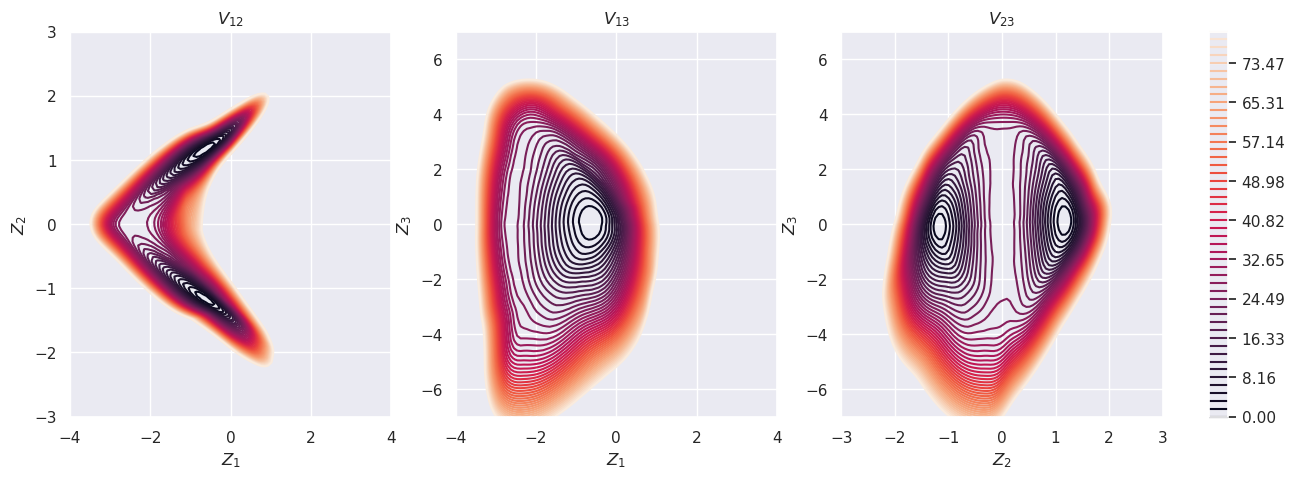

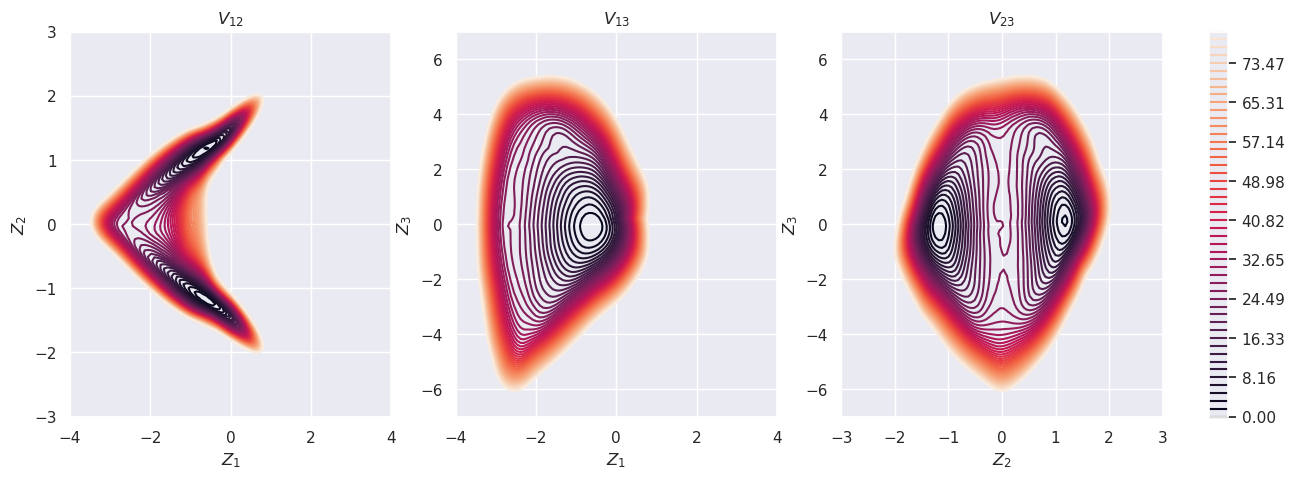

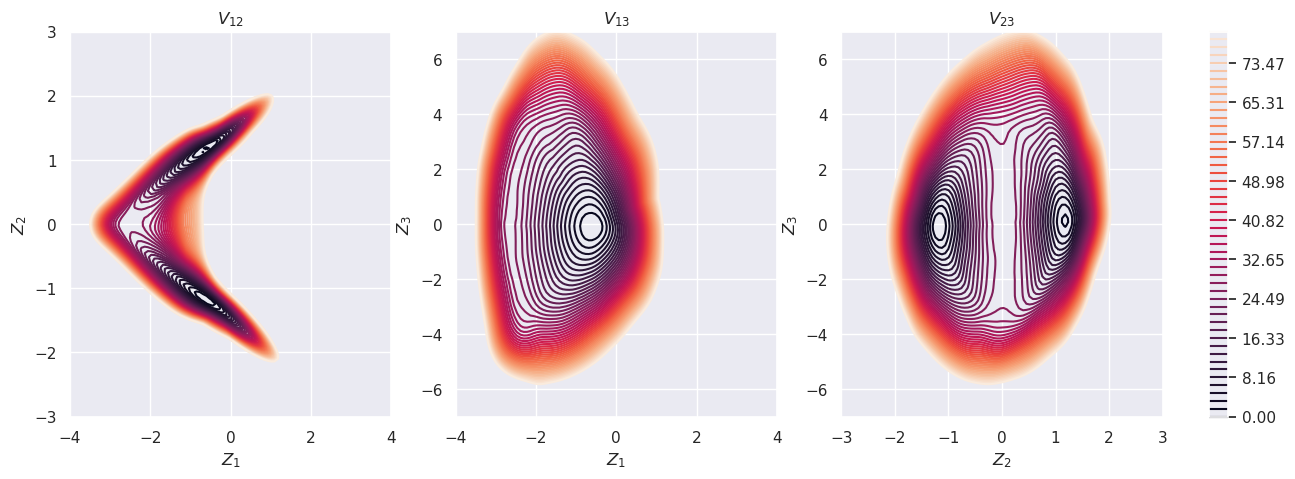

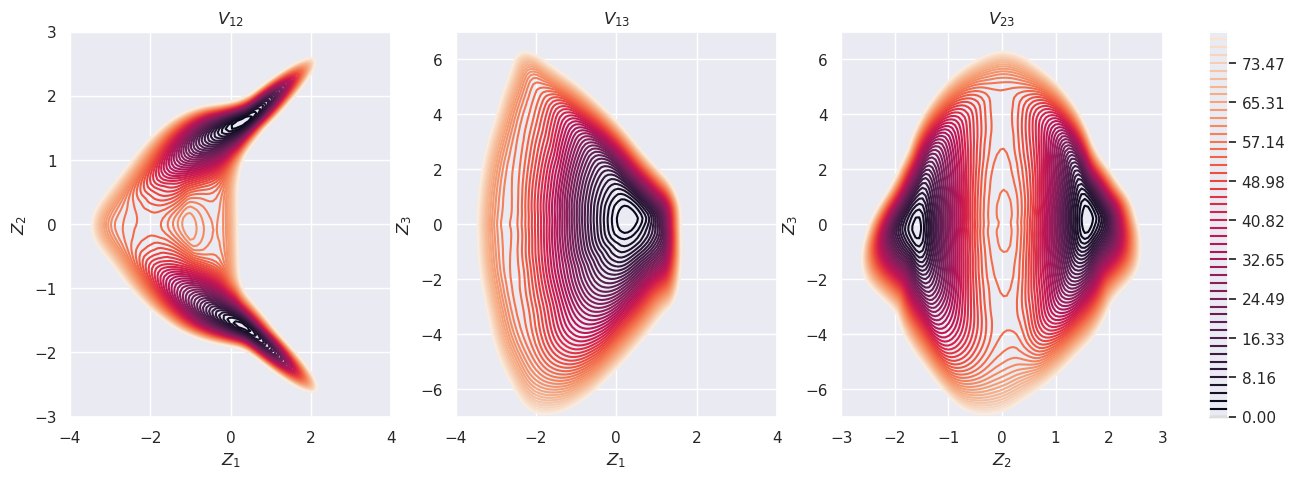

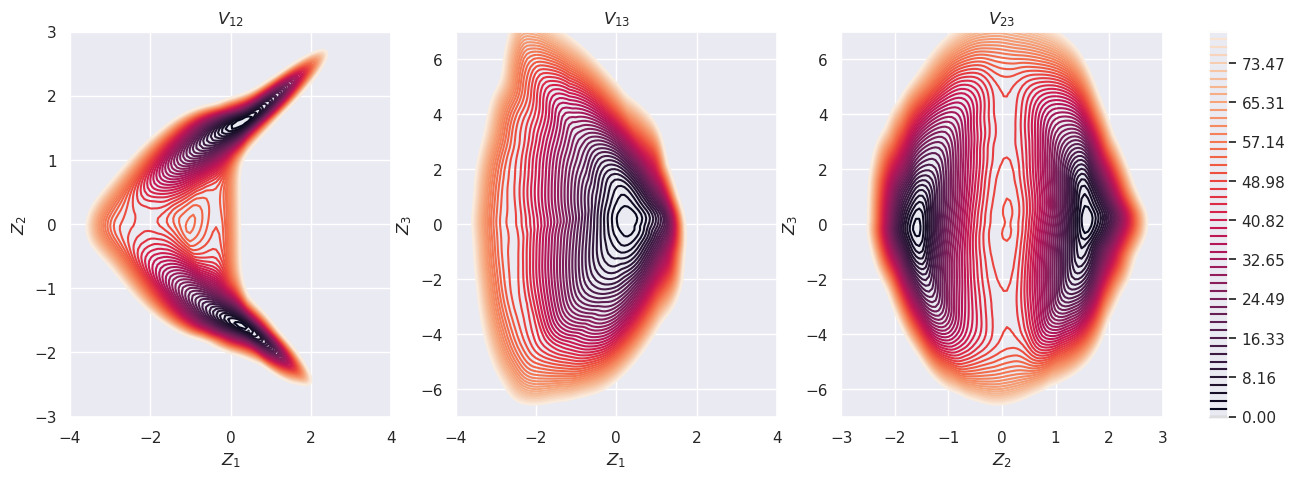

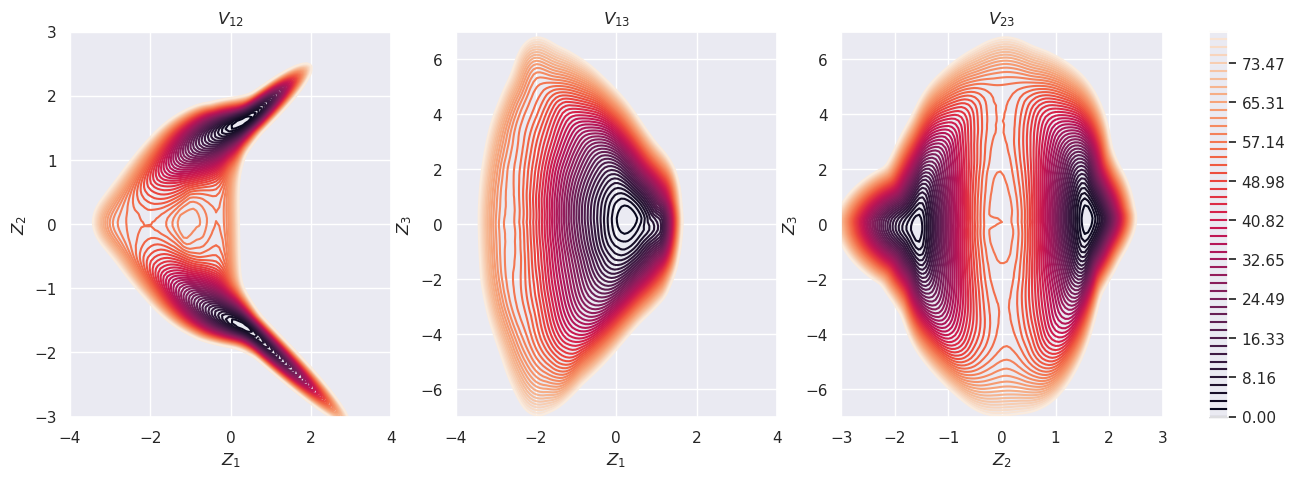

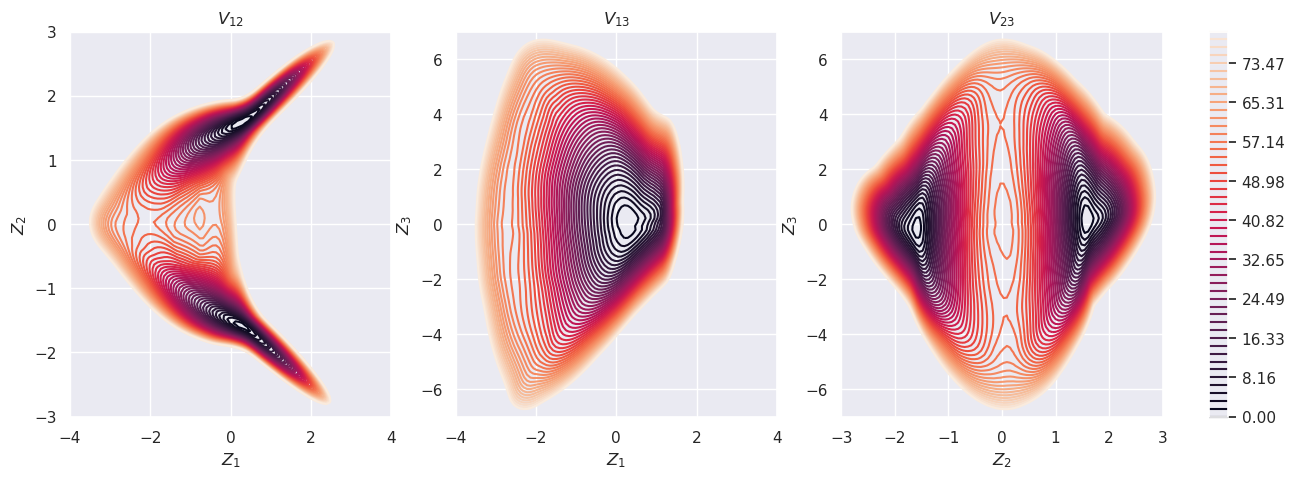

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import seaborn as sns; sns.set_theme() 
from omegaconf import OmegaConf
from utils_reduced_polymer import PlotV

import jax.numpy as jnp
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from examples.utils.sde import SDEIntegrator
from utils_reduced_polymer import build_OnsagerNetHD2_scale, build_OnsagerNet, PlotV
from utils_reduced_polymer import entropy_production_polymer
def scale_number(F):
    return 2**(F/3)/3
scale_list={"F23_10_T1": scale_number(23.1), "F16_20_T1": scale_number(16.2), "F11_60_T1":scale_number(11.6),"F4_63_T1": scale_number(4.63), 
            "F3_93_T1": scale_number(3.93), "F2_78_T1": scale_number(2.78), "F2_31_T1": scale_number(2.31), "F1_62_T1": scale_number(1.62)}

data_set_key_list=["F1_62_T10","F1_62_T5","F1_62_T2_25", "F1_62_T0_5","F1_62_T0_25", 
                  ]
os.makedirs("Figure", exist_ok=True)

def plot_V_dataset(data_set_key, level_end):
    for seed in [0,1, 12, 123]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template) 
        fig, ax = PlotV(net, config, level_end)
        fig.savefig(os.path.join("Figure", f"seed_{seed}_" + data_set_key + '.pdf'), dpi=300, bbox_inches='tight')


plot_V_dataset(data_set_key = "F1_62_T10", level_end=300)
# plot_V_dataset(data_set_key = "F1_62_T5", level_end=200)
# plot_V_dataset(data_set_key = "F1_62_T2_25", level_end=100)
plot_V_dataset(data_set_key = "F1_62_T0_5", level_end=80)
plot_V_dataset(data_set_key = "F1_62_T0_25", level_end=80)








In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import seaborn as sns; sns.set_theme() 
from omegaconf import OmegaConf
from utils_reduced_polymer import PlotV

import jax.numpy as jnp
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from examples.utils.sde import SDEIntegrator
from utils_reduced_polymer import build_OnsagerNetHD2_scale, build_OnsagerNet, PlotV
from utils_reduced_polymer import entropy_production_polymer

data_set_key_list=["F1_62_T10","F1_62_T5","F1_62_T2_25", "F1_62_T0_5","F1_62_T0_25"
                  ] 
temperature_list = [10, 5, 2.25, 0.5, 0.25]
ep_dict = {'F1_62_T1': jnp.array([36.78315 , 36.50363 , 36.49664 , 36.477352])}
for k, data_set_key in enumerate(data_set_key_list):
    print("temperature", temperature_list[k])
    ep_list=[]
    for seed in [0,1, 12, 123]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template)  
        ep, _ = entropy_production_polymer(net, temperature=temperature_list[k], end_time=5, dt=0.0001)
        ep_list.append(ep)
    ep_array = jnp.array(ep_list)
    ep_dict[data_set_key] = ep_array




temperature 10
temperature 5
temperature 2.25
temperature 0.5
temperature 0.25


In [3]:
print(ep_dict)

{'F1_62_T1': Array([36.78315 , 36.50363 , 36.49664 , 36.477352], dtype=float32), 'F1_62_T10': Array([2759.3936, 2858.9304, 2738.8406, 2918.9314], dtype=float32), 'F1_62_T5': Array([805.4863 , 794.18945, 768.9742 , 754.6266 ], dtype=float32), 'F1_62_T2_25': Array([170.22125, 171.72678, 171.01805, 163.73457], dtype=float32), 'F1_62_T0_5': Array([11.90035 , 11.478205, 11.786741, 11.926412], dtype=float32), 'F1_62_T0_25': Array([5.408261 , 5.3051996, 5.226646 , 5.505894 ], dtype=float32)}


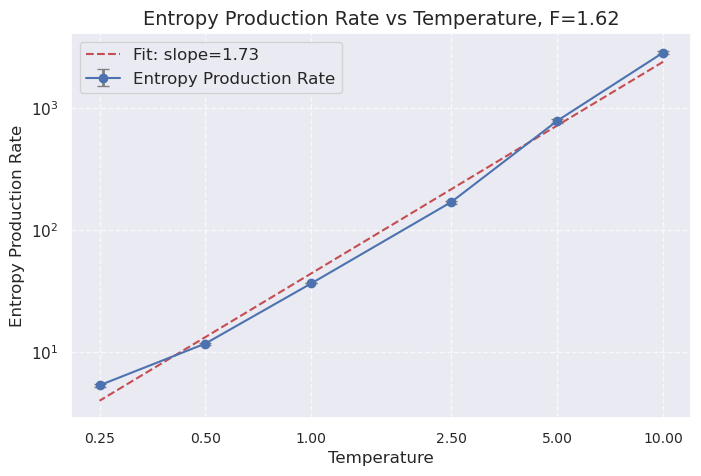

In [4]:

key_order=["F1_62_T10","F1_62_T5", "F1_62_T2_25", "F1_62_T1", "F1_62_T0_5", "F1_62_T0_25"]
ep_array = jnp.array([ep_dict[key] for key in key_order])
ep_key_list = list(ep_dict.keys())

scale_list=[10., 5.,2.5,1.,0.5,0.25]

ep_mean = ep_array.mean(axis=1)
max_value = ep_array.max(axis=1)
min_value = ep_array.min(axis=1)
yerr = jnp.vstack((ep_mean - min_value, max_value - ep_mean))

plt.figure(figsize=(8, 5))
# plt.plot(scale_list, ep_mean, marker='o', linestyle='-', color='b', label='Entropy Production Rate')
plt.errorbar(scale_list, ep_mean, yerr=yerr, fmt='o-', color='b', ecolor='gray', elinewidth=2, capsize=4, label='Entropy Production Rate')
#
# 线性拟合
log_scale_list = jnp.log10(jnp.array(scale_list))
log_ep_mean = jnp.log10(ep_mean)
coefficients = jnp.polyfit(log_scale_list, log_ep_mean, 1)
slope, intercept = coefficients
fit_line = 10**(slope * jnp.log10(jnp.array(scale_list)) + intercept)

plt.plot(scale_list, fit_line, linestyle='--', color='r', label=f'Fit: slope={slope:.2f}') 


plt.xscale('log')
plt.yscale('log')

# 设置横轴刻度标签
plt.xticks(scale_list, [f'{x:.2f}' for x in scale_list], fontsize=10)

# 添加标题和标签
plt.title('Entropy Production Rate vs Temperature, F=1.62', fontsize=14)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Entropy Production Rate', fontsize=12)

# 添加网格和图例
plt.grid(True, linestyle='--', alpha=0.7) 
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]  # 调整顺序，0 表示 'Entropy Production Rate'，1 表示 'Fit'
plt.legend(fontsize=12)
plt.savefig("Figure/entropy_production_rate_vs_Temperature_F1_62.pdf", dpi=300, bbox_inches='tight')


In [ ]:
# 计算最大值、最小值和均值
max_value = ep_array.max(axis=1)
min_value = ep_array.min(axis=1)
ep_mean = ep_array.mean(axis=1)

# 计算误差棒的上下界
yerr = jnp.vstack((ep_mean - min_value, max_value - ep_mean))

# 绘制误差棒图
plt.figure(figsize=(8, 6))
plt.errorbar(scale_list, ep_mean, yerr=yerr, fmt='o-', color='b', ecolor='gray', elinewidth=2, capsize=4, label='Entropy Production Rate')

# 设置对数刻度
plt.xscale('log')
plt.yscale('log')

# 绘制拟合直线
fit_line = 10**(slope * jnp.log10(jnp.array([2., 23.])) + intercept)
plt.plot([2., 23.], fit_line, linestyle='--', color='r', label=f'Fit: slope={slope:.2f}')

# 添加标题和标签
plt.title('Entropy Production Rate with Error Bars', fontsize=14)
plt.xlabel('Force', fontsize=12)
plt.ylabel('Entropy Production Rate', fontsize=12)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

# 调整图例顺序
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1]  # 调整顺序，0 表示 'Entropy Production Rate'，1 表示 'Fit'
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12)

# 显示图形
plt.show()


In [ ]:
# 绘制图形
plt.figure(figsize=(8, 6))
plt.plot(scale_list, ep_mean, marker='o', linestyle='-', color='b', label='Entropy Production')

# 设置对数刻度
plt.xscale('log')

# 设置对数刻度
plt.yscale('log')

#
log_scale_list = jnp.log10(scale_list)
log_ep_mean = jnp.log10(ep_mean)

# 线性拟合
coefficients = jnp.polyfit(log_scale_list, log_ep_mean, 1)
slope, intercept = coefficients

# 绘制拟合直线
fit_line = 10**(slope * log_scale_list + intercept)
plt.plot(scale_list, fit_line, linestyle='--', color='r', label=f'Fit: slope={slope:.2f}')

# 设置横轴刻度标签
plt.xticks(scale_list, [f'{x:.2f}' for x in scale_list], fontsize=10)

# 添加标题和标签
plt.title('Entropy Production vs Scale (Log Scale)', fontsize=14)
plt.xlabel('Scale (log)', fontsize=12)
plt.ylabel('Entropy Production (log)', fontsize=12)

# 添加网格和图例
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# 显示图形
plt.show()
